In [1]:
from albumentations import (Compose, 
                            HorizontalFlip,
                            GridDropout, 
                            ShiftScaleRotate,
                            GaussNoise, 
                            CoarseDropout,
                            Affine)
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))


/home/nick12138/anaconda3/envs/rotten-tomatoes/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nick12138/anaconda3/envs/rotten-tomatoes/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from utils.data import transforms_dict, rl_decode
# corruption_transforms = Compose([
#     GaussNoise(p=0.7, var_limit=(1, 5)),
#     CoarseDropout(p=0.7, num_holes_range=(5000, 10000))
# ])

# augmentation_transforms = Compose([
#     Affine(rotate=(-360, 360), translate_percent=0.25, p=0.7)
# ])

# transforms_dict = {
#     "augmentation_transforms": augmentation_transforms,
#     "corruption_transforms": corruption_transforms
# }

In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
def run_length_encode(mask):
    enc = []
    cache_val = mask[0]
    val_counter = 0

    for i in range(len(mask)):
        if cache_val != mask[i]:
            enc.append(str(val_counter))
            enc.append(str(cache_val))
            val_counter = 0

        cache_val = mask[i]
        val_counter += 1

        if i == (len(mask) - 1):
            enc.append(str(val_counter))
            enc.append(str(cache_val))

    return " ".join(enc)

def encode_mask(mask: torch.Tensor, threshold: float):
    # Resize the mask first
    mask = resize_mask(mask)

    # Apply transformations
    mask = (mask.sigmoid() > threshold).long().flatten().tolist()

    return run_length_encode(mask)

def encode_mask_img(mask: Image.Image):
    mask = np.array(mask)
    # print(mask.shape)
    mask = mask.flatten().tolist()

    return run_length_encode(mask)

def display_image_and_mask(image, mask, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Leaf Sample')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

def data_transform(source_path, mask_csv_path, transforms=transforms_dict):
    
    mask_encoded = pd.read_csv(mask_csv_path)
    
    for _, row in mask_encoded.iterrows():
        mask = rl_decode(row['annotation'])
        # mask = Image.fromarray(mask)
        image_id = row['id']
        img_path = f"{source_path}/{image_id}.jpg"
        img = np.array(Image.open(img_path))
        if transforms:
            # augmented = transform(image=img, mask=mask)
            augmented = transforms["augmentation_transforms"](image=img, mask=mask)
            img = transforms["corruption_transforms"](image=augmented["image"])["image"]
            mask = augmented['mask']
            # img = augmented['image']
        display_image_and_mask(img, mask)


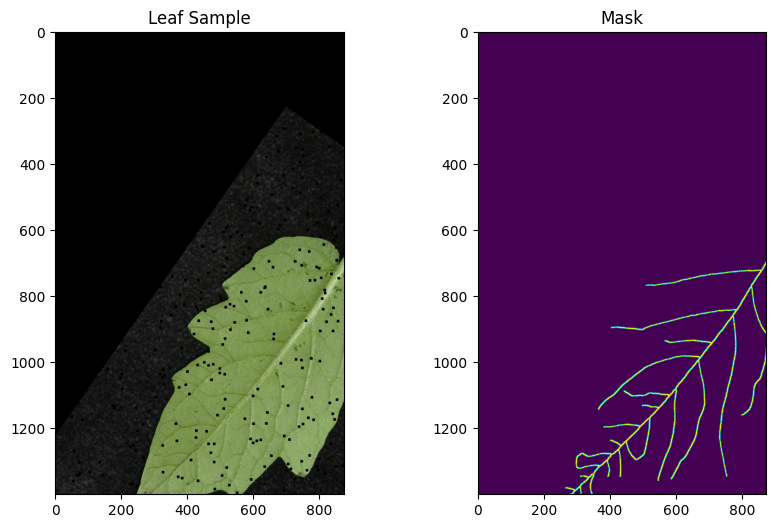

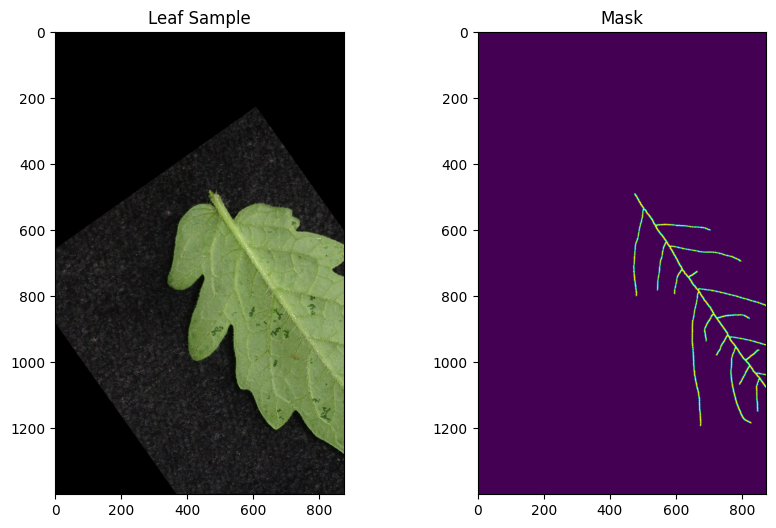

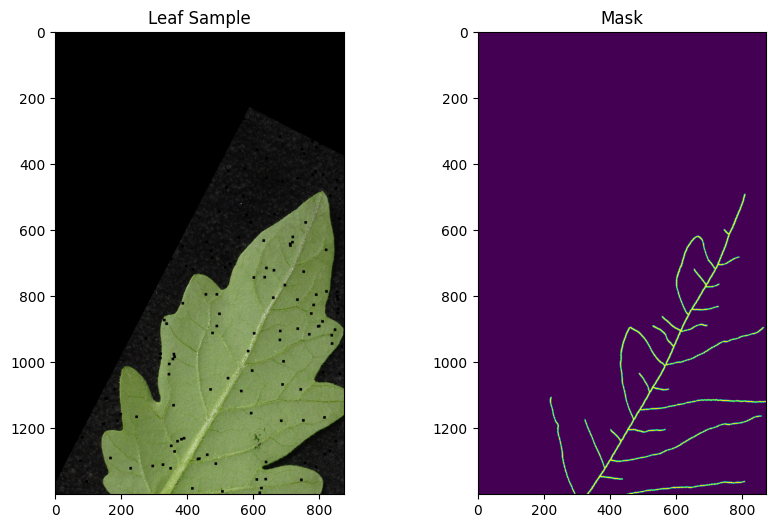

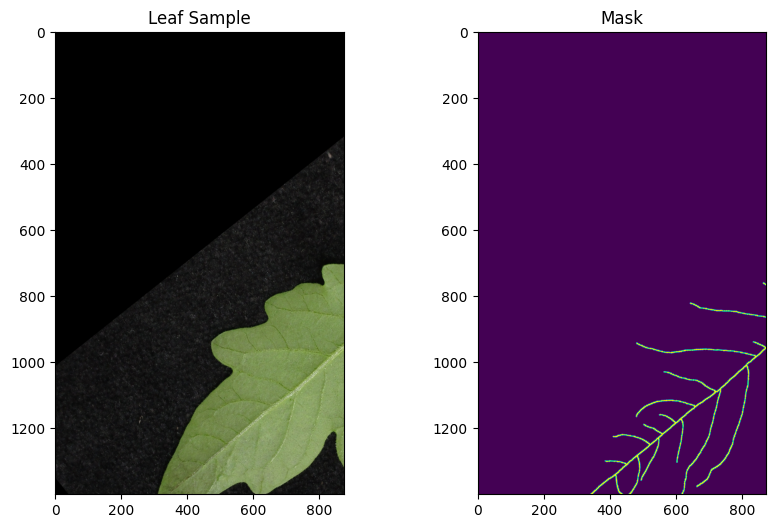

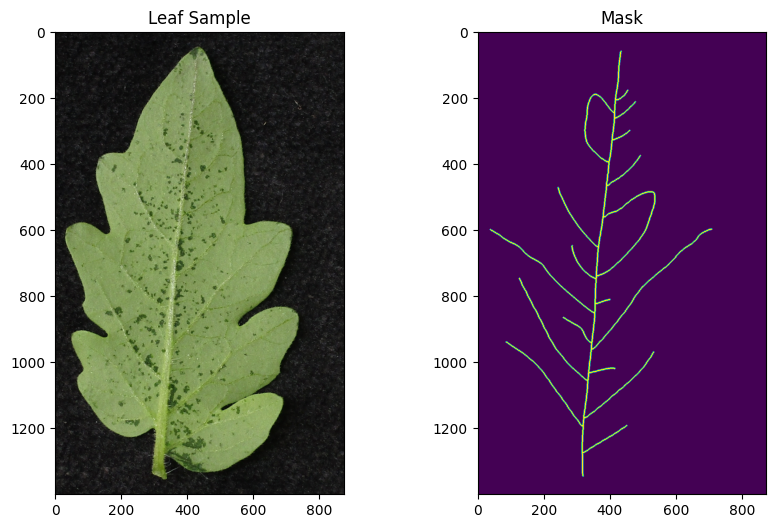

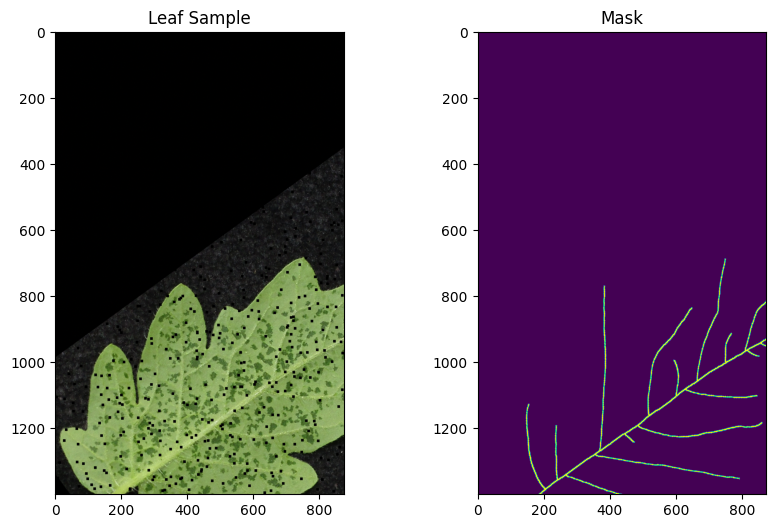

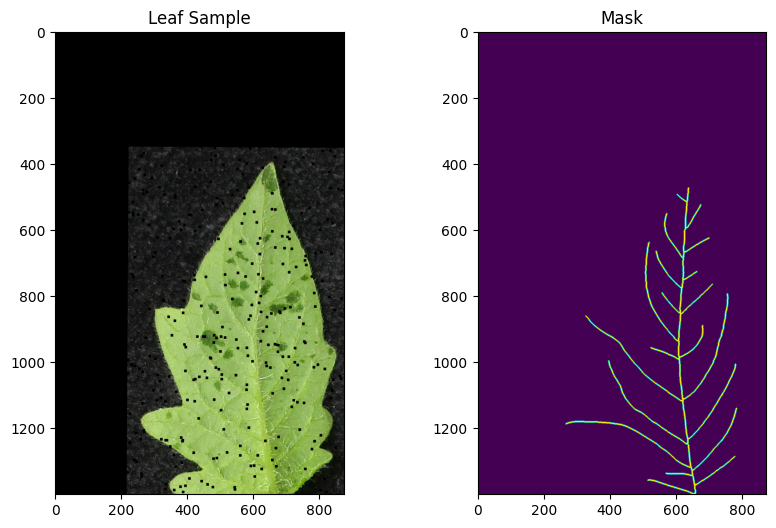

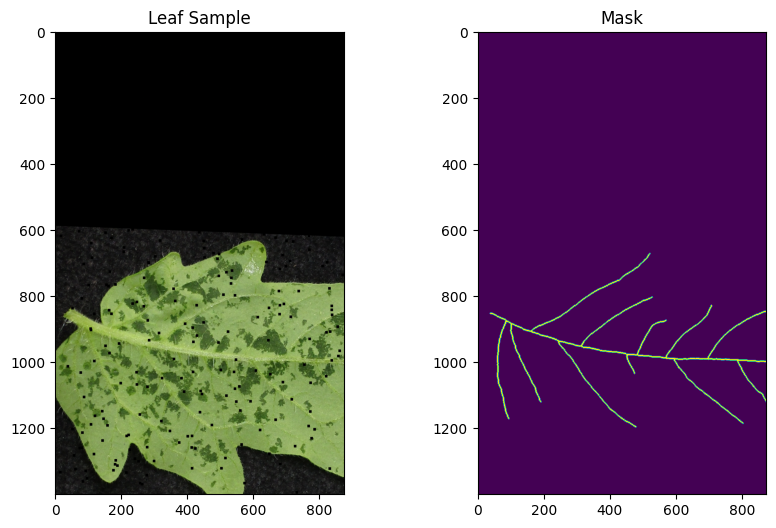

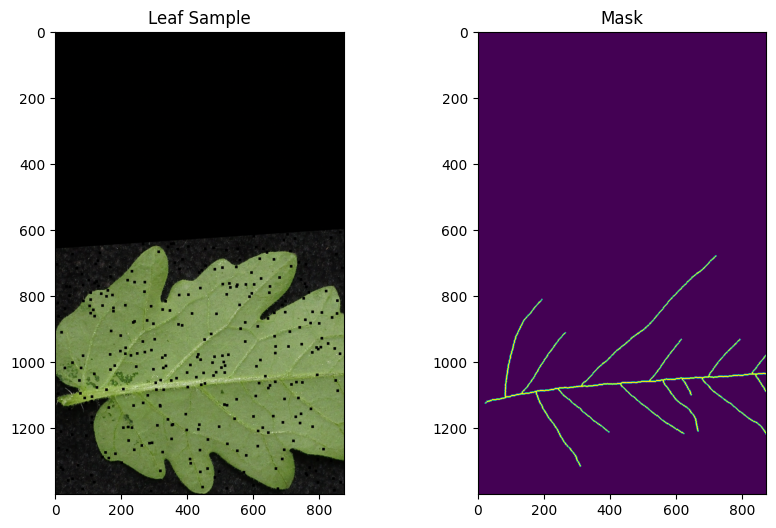

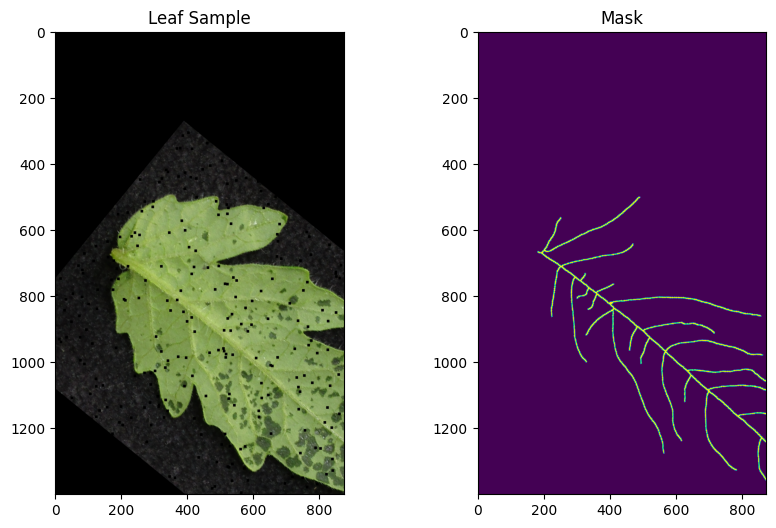

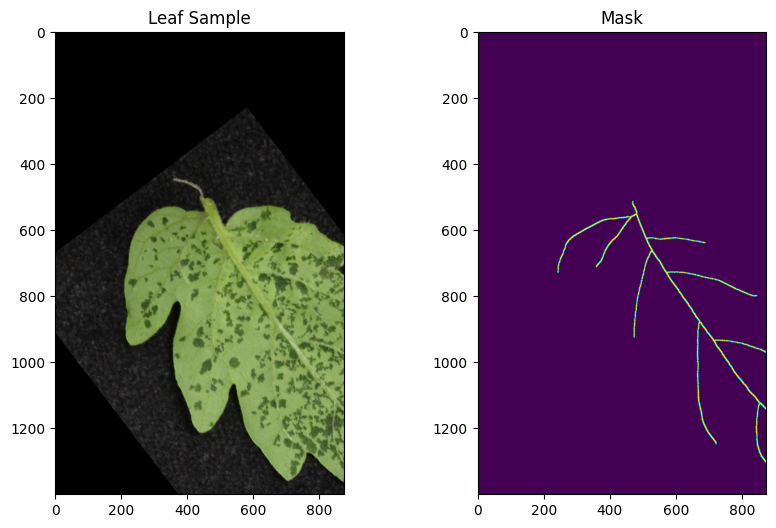

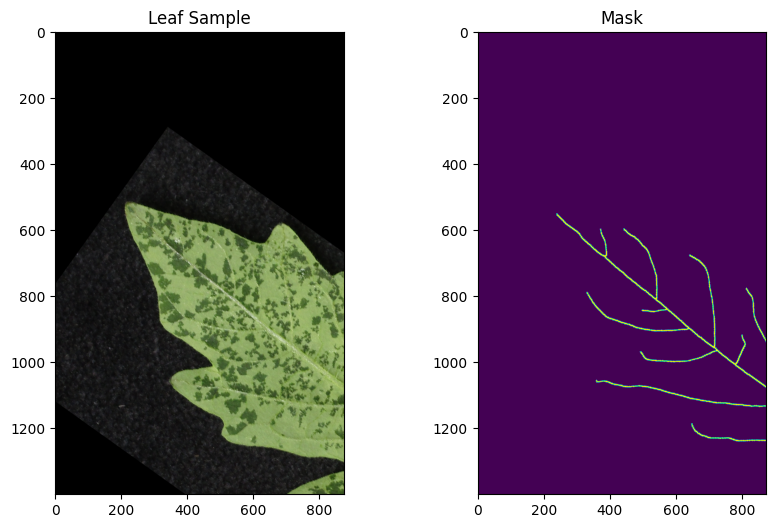

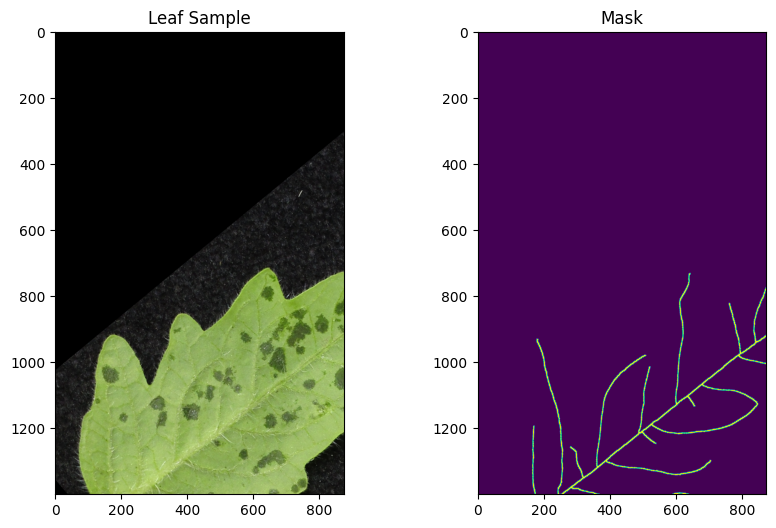

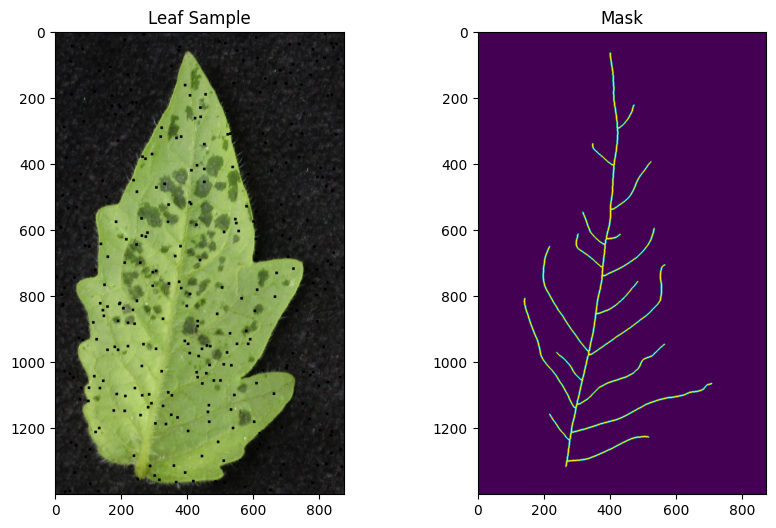

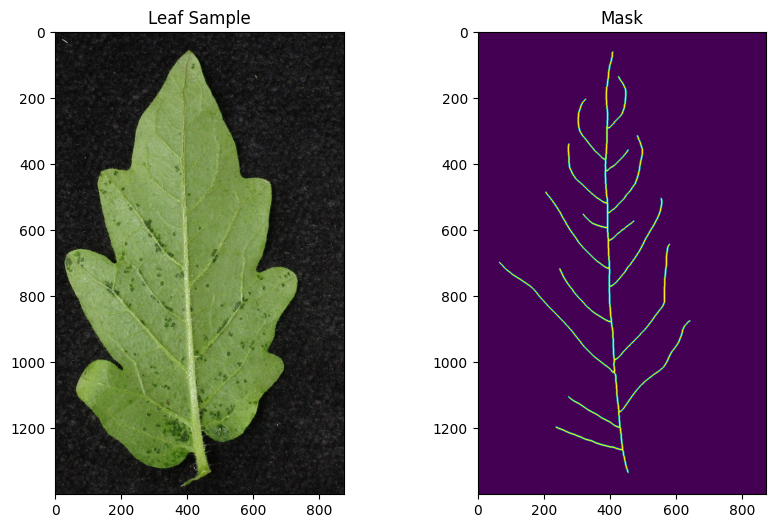

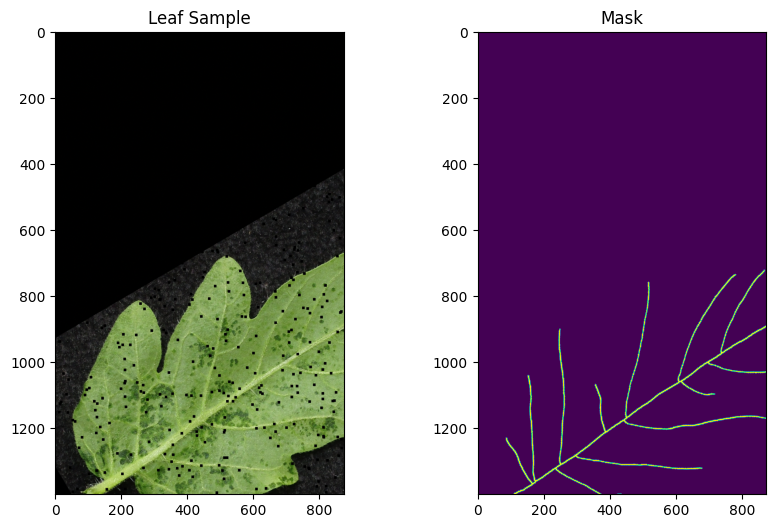

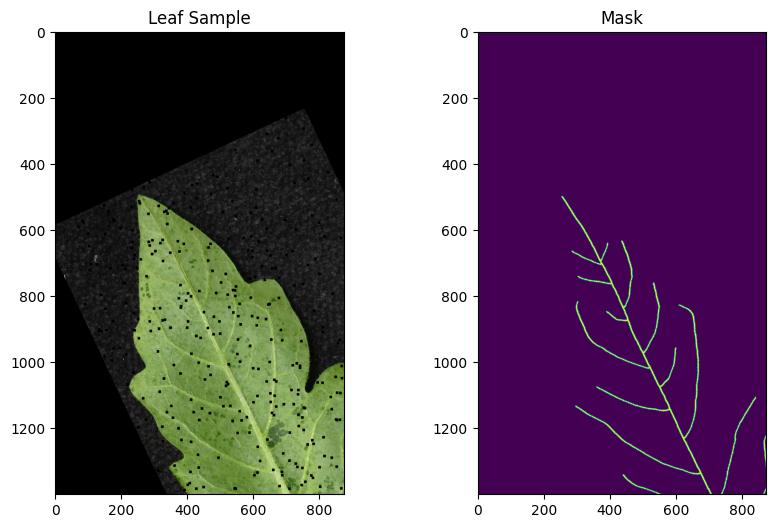

In [4]:
train_path = "../data/leaf_veins"
mask_csv_path = os.path.join(train_path, "train.csv")
image_path = os.path.join(train_path, "train/")


# mask_transform(mask_csv_path, dest_dir, transform=transform)
# image_transform(image_path, dest_dir, transform=transform)

data_transform(image_path, mask_csv_path)